In [410]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import networkx as nx
import math
import random

from e3nn import o3
from tqdm import tqdm
from torch_geometric.datasets import QM9
from torch_geometric.utils import to_networkx, to_undirected
from torch_geometric.data import Data

from cartesian_mace.modules.tensor_contraction_block import CartesianContraction
from cartesian_mace.utils.cartesian_contractions import count_contractions, contraction_is_valid
from cartesian_mace.models.model import CartesianMACE
from src.models import MACEModel
from src.modules.symmetric_contraction import Contraction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [275]:
# define some hyperparameters
max_ell = 2
nu = 4

In [276]:
# n_indices: tensor product order
# c_out: number of free indices of equivariants
# dim: in dimension of the tensors in (this will be changed at some point)
n_indices = 6
c_out = 0
n_channels = 4
dim=3


cartesian_contraction = CartesianContraction(n_indices=n_indices, c_out=c_out, dim=dim, n_channels=n_channels, split=[n_indices], n_extra_dim=1)
# irreps_in: o3.Irreps,
# irrep_out: o3.Irreps,
# correlation: int,

irreps_in = o3.Irreps([(1,(n_indices, 1))])
irrep_out = o3.Irreps([(1,(c_out, 1))])

# spherical_contraction = Contraction(irreps_in=irreps_in, irrep_out=irrep_out, correlation=4) # 'last_ir' referenced before assignment

In [293]:
results = []
tensors_out = []
n_indices_list = [2,4,6,8,10]

for n_indices in tqdm(n_indices_list):

    shape = [n_channels] + [dim] * n_indices

    tensors_in = torch.randn(shape)

    cartesian_contraction = CartesianContraction(n_indices=n_indices, c_out=c_out, dim=dim, n_channels=n_channels, split=[n_indices], n_extra_dim=1)

    tensors_out.append(cartesian_contraction([tensors_in]))

    timing_result = %timeit -o -q cartesian_contraction([tensors_in])

    results.append(timing_result.average)

print(results)

  0%|          | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

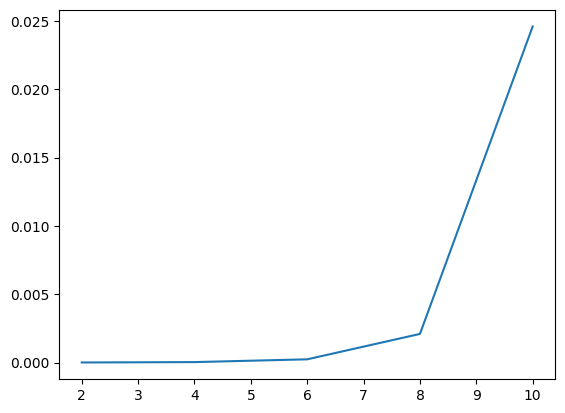

In [278]:
plt.plot(n_indices_list, results)
# plt.yscale('log') # combinatorial relationship
plt.show()

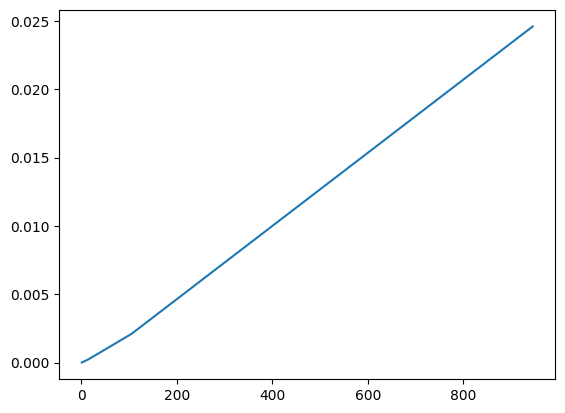

In [279]:
n_contractions = [count_contractions(n_indices, n_indices/2) for n_indices in n_indices_list]

plt.plot(n_contractions, results)
plt.show()

In [280]:
n_contractions == [len(out) for out in tensors_out] # nice!

True

# Testing model performance

In [303]:
path = './qm9'
target = 0

# Transforms which are applied during data loading:
# (1) Fully connect the graphs, (2) Select the target/label
# transform = T.Compose([CompleteGraph(), SetTarget()])
#
# Load the QM9 dataset with the transforms defined
dataset = QM9(path)

data = dataset[10]

In [304]:
def to_nx(data):
    # Convert the PyTorch Geometric Data object to a NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Transfer the node features to the NetworkX graph as node attributes
    for i, nf in enumerate(data.x.tolist()):
        G.nodes[i]['features'] = nf

    return G

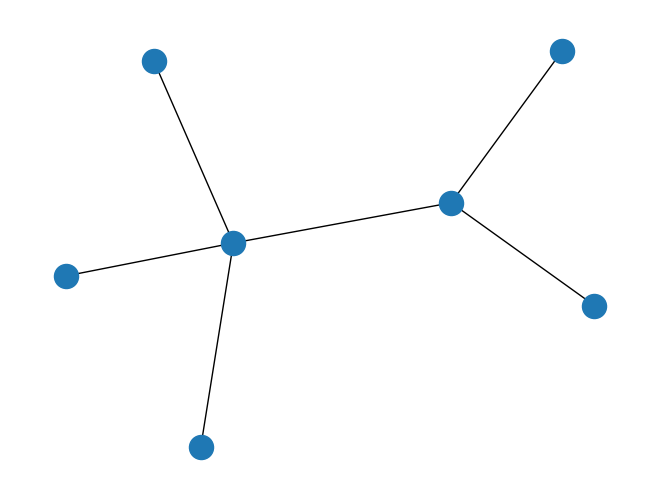

In [305]:
G = to_nx(data)
nx.draw(G) # i.e. this is ethanol or something similar

In [306]:
def create_rotsym_envs(fold=3):
    dataset = []

    # Environment 0
    atoms = torch.LongTensor([ 0 ] + [ 0 ] * fold)
    edge_index = torch.LongTensor( [ [0] * fold, [i for i in range(1, fold+1)] ] )
    x = torch.Tensor([1,0,0])
    pos = [
        torch.Tensor([0,0,0]),  # origin
        x,   # first spoke
    ]
    for count in range(1, fold):
        R = o3.matrix_z(torch.Tensor([2*math.pi/fold * count])).squeeze(0)
        pos.append(x @ R.T)
    pos = torch.stack(pos)
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)

    # Environment 1
    q = 2*math.pi/(fold + random.randint(1, fold))
    assert q < 2*math.pi/fold
    Q = o3.matrix_z(torch.Tensor([q])).squeeze(0)
    pos = pos @ Q.T
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)

    return dataset

In [302]:
# hyperparams
n_channels = 4
self_tp_rank_max = 2
basis_rank_max = 2
dim = 3
n_layers = 1
nu_max = 1
feature_rank_max = 2

In [359]:
cmace_results = []
mace_results = []

# hyperparams
n_channels = 4
self_tp_rank_max = 2
basis_rank_max = 2
dim = 3
n_layers = 3
nu_max = 1
feature_rank_max = 2

nu_max_list = [1,2,3,4] # max of 5

for nu_max in tqdm(nu_max_list):

    shape = [n_channels] + [dim] * n_indices

    tensors_in = torch.randn(shape)

    cartesian_mace = CartesianMACE(
        n_channels=n_channels,
        self_tp_rank_max=self_tp_rank_max,
        basis_rank_max=basis_rank_max,
        dim=dim,
        n_layers=n_layers,
        nu_max=nu_max,
        feature_rank_max=feature_rank_max,
    )

    timing_result = %timeit -o -q cartesian_mace(data)
    cmace_results.append(timing_result.average)

    mace = MACEModel(
        scalar_pred=False,
        correlation=nu_max,
        num_layers=n_layers,
        out_dim=2,
        max_ell=self_tp_rank_max,
        emb_dim=n_channels,
    )

    timing_result = %timeit -o -q mace(data)
    mace_results.append(timing_result.average)



100%|██████████| 4/4 [00:47<00:00, 11.94s/it]


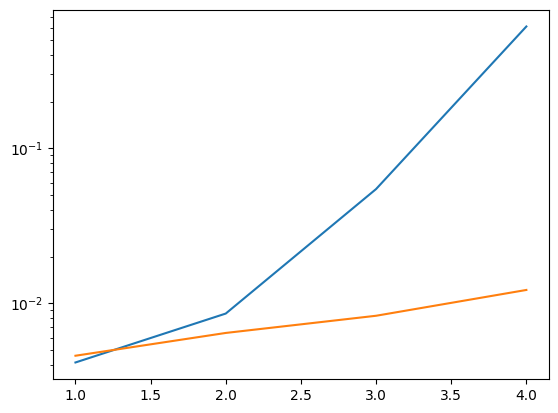

In [361]:
plt.plot(nu_max_list, cmace_results)
plt.plot(nu_max_list, mace_results)
plt.yscale('log')
plt.show()

In [367]:
mace = MACEModel(
    scalar_pred=False,
    correlation=3,
    num_layers=1,
    out_dim=2,
    max_ell=self_tp_rank_max,
    emb_dim=n_channels,
)

%timeit mace(data)

2.22 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [365]:


%timeit -o -q cartesian_mace(data) # why on earth is it so much slower?

<TimeitResult : 5.25 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)>

In [369]:
for n in []
    print(count_contractions(n=n, n_contractions=n_contractions))

TypeError: count_contractions() missing 2 required positional arguments: 'n' and 'n_contractions'

In [373]:
def find_combinations(n, nu, c_max: Optional[int] = 2):
    def helper(n, nu, current_combination, start):
        if n == 0 and nu == 0:
            combinations.append(current_combination[:])
            return

        if n < 0 or nu == 0:
            return

        for i in range(start, c_max + 1):
            current_combination.append(i)
            helper(n - i, nu - 1, current_combination, i)
            current_combination.pop()

    combinations = []
    helper(n, nu, [], 0)
    return combinations

In [374]:
find_combinations(n=6, nu=3)

[[2, 2, 2]]

In [415]:
l = []

for nu in [1,2,3,4]:

    for n in range(1,2*nu+1,2):

        n_contractions = int(n / 2)

        if contraction_is_valid(n, 1):

            n_contractions = int(n / 2 - 0.5)

            print(count_contractions(n=n, n_contractions=n_contractions))
            print(find_combinations(n=n, nu=nu))

            l.append(count_contractions(n=n, n_contractions=n_contractions) * len(find_combinations(n=n, nu=nu)))

1
[[1]]
1
[[0, 1]]
3
[[1, 2]]
1
[[0, 0, 1]]
3
[[0, 1, 2], [1, 1, 1]]
15
[[1, 2, 2]]
1
[[0, 0, 0, 1]]
3
[[0, 0, 1, 2], [0, 1, 1, 1]]
15
[[0, 1, 2, 2], [1, 1, 1, 2]]
105
[[1, 2, 2, 2]]


In [416]:
l = torch.Tensor(l)

torch.cumsum(l, dim=0)

tensor([  1.,   2.,   5.,   6.,  12.,  27.,  28.,  34.,  64., 169.])

In [412]:
for n in range print(contraction_is_valid(n, 1))

TypeError: contraction_is_valid() missing 2 required positional arguments: 'num_legs_in' and 'num_legs_out'